In [26]:
import pandas as pd

data = pd.read_csv('training_data.csv')
data.patient = data.patient.astype(str).str.zfill(3)
data

,patient,image,channel
0,001,LA_ED,0
1,001,LA_ES,0
2,001,SA_ED,0
3,001,SA_ED,1
4,001,SA_ED,2
...,...,...,...
3869,160,SA_ES,2
3870,160,SA_ES,3
3871,160,SA_ES,4
3872,160,SA_ES,5


In [33]:
import torch 
import nibabel as nib

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, path = 'data/MnM-2/training', trans=None):
        self.path = path
        self.data = data
        self.trans = trans
        self.num_classes = 4
        self.max_val = {
            'LA_ED': 4104.,
            'LA_ES': 7875.,
            'SA_ED': 11510.,
            'SA_ES': 9182.
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, ix):
        patient = self.data.iloc[ix].patient
        image = self.data.iloc[ix].image
        channel = self.data.iloc[ix].channel

        img = nib.load(f'{self.path}/{patient}/{patient}_{image}.nii.gz').get_fdata()[...,channel] / self.max_val[image]
        mask = nib.load(f'{self.path}/{patient}/{patient}_{image}_gt.nii.gz').get_fdata()[...,channel].astype(np.int)
        if self.trans:
            t = self.trans(image=img, mask=mask)
            img = t['image']
            mask = t['mask'] 
        img_t = torch.from_numpy(img).float().unsqueeze(0)
        # mask encoding
        mask_oh = torch.nn.functional.one_hot(torch.from_numpy(mask).long(), self.num_classes).permute(2,0,1).float()
        return img_t, mask_oh

In [41]:
import albumentations as A

trans = A.Compose([
    A.Resize(224, 224)
])

ds = Dataset(data, trans=trans)

img, mask = ds[0]
img.shape, mask.shape

C:\Users\sensio\miniconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(torch.Size([1, 224, 224]), torch.Size([4, 224, 224]))

C:\Users\sensio\miniconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


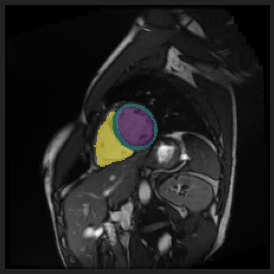

In [98]:
import matplotlib.pyplot as plt
import random

ix = random.randint(0, len(ds))
img, mask = ds[ix]
fig, ax = plt.subplots(dpi=50)
ax.imshow(img[0], cmap="gray")
ax.axis('off')
mask = torch.argmax(mask, axis=0).float().numpy()
mask[mask == 0] = np.nan
ax.imshow(mask, alpha=0.5)
plt.show()

In [100]:
dl = torch.utils.data.DataLoader(ds, batch_size=10, shuffle=False)

imgs, masks = next(iter(dl))
imgs.shape, masks.shape

C:\Users\sensio\miniconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(torch.Size([10, 1, 224, 224]), torch.Size([10, 4, 224, 224]))

In [101]:
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
    return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

In [110]:
class UNet(torch.nn.Module):
    def __init__(self, n_classes=4, in_ch=1):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

In [111]:
unet = UNet()

output = unet(imgs)
output.shape, masks.shape

(torch.Size([10, 4, 224, 224]), torch.Size([10, 4, 224, 224]))

In [151]:
dl = torch.utils.data.DataLoader(ds, batch_size=10, shuffle=False)
unet = UNet()

In [152]:
from tqdm import tqdm

epochs = 200
lr = 1e-3
optimizer = torch.optim.Adam(unet.parameters(), lr=lr)

for e in range(1, epochs+1):
    unet.train()
    l = []
    for batch in tqdm(dl):
        optimizer.zero_grad()
        imgs, masks = batch
        preds = unet(imgs)
        loss = F.binary_cross_entropy_with_logits(preds, masks)
        loss.backward()
        optimizer.step()
        l.append(loss.item())
        break
    print(f'Epoch {e}/{epochs} loss {np.mean(l):.4f}')

  0%|                                                                                          | 0/388 [00:00<?, ?it/s]C:\Users\sensio\miniconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  0%|                                                                                          | 0/388 [00:00<?, ?it/s]

Epoch 1/200 loss 0.6999


  0%|                                                                                          | 0/388 [00:00<?, ?it/s]

Epoch 2/200 loss 0.6686


  0%|                                                                                          | 0/388 [00:00<?, ?it/s]

Epoch 3/200 loss 0.6419


  0%|                                                                                          | 0/388 [00:00<?, ?it/s]

Epoch 4/200 loss 0.6130


  0%|                                                                                          | 0/388 [00:00<?, ?it/s]

Epoch 5/200 loss 0.5838


  0%|                                                                                          | 0/388 [00:00<?, ?it/s]

Epoch 6/200 loss 0.5560


  0%|                                                                                          | 0/388 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [149]:
unet.eval()
imgs, masks = next(iter(dl))
with torch.no_grad():
    preds = unet(imgs)
    
preds.shape

C:\Users\sensio\miniconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


torch.Size([3, 4, 224, 224])

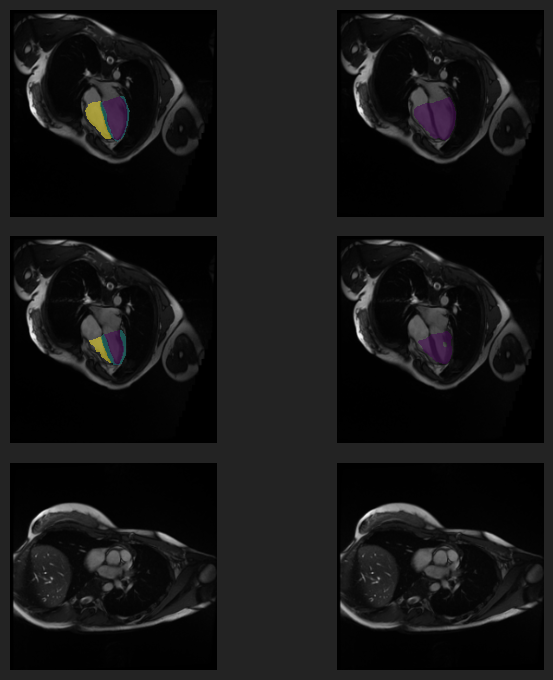

In [150]:
fig = plt.subplots(dpi=100)
for i, (img, mask, pred) in enumerate(zip(imgs, masks, preds)):
    ax = plt.subplot(len(imgs), 2, 2*i + 1)
    ax.imshow(img[0], cmap="gray")
    mask = torch.argmax(mask, axis=0).float().numpy()
    mask[mask == 0] = np.nan
    ax.imshow(mask, alpha=0.5)
    ax.axis('off')
    ax = plt.subplot(len(imgs), 2, 2*i + 2)
    ax.imshow(img[0], cmap="gray")
    pred = torch.argmax(pred, axis=0).float().numpy()
    pred[pred == 0] = np.nan
    ax.imshow(pred, alpha=0.5)
    ax.axis('off')
plt.tight_layout()    
plt.show()